In [1]:
# Importing dependencies
import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import data_prep_helper
plt.style.use('ggplot')

Using TensorFlow backend.


### Data Preprocessing

In [2]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [3]:
# Loading the dataset
do = data_prep_helper.ShiftChartData(chart_col=["Price", "High", "Low"])

In [4]:
df = do.chart_df

In [5]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [6]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse,rmse, r2, Y_test, Y_hat
  

In [7]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [8]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [36]:
features = [
             'bitcoin_Price_prev_month',
             'bitcoin_High_prev_month',
             'bitcoin_Low_prev_month',
             'alibaba_Price_prev_month',
             'alibaba_High_prev_month',
             'alibaba_Low_prev_month',
             'bitcoin_Google_Trends_prev_month',
             'economy_pos_sents_prev_month',
             'cryptocurrency_Google_Trends_prev_month',
             'month-1', 'month-2']

In [61]:
#creating the train and validation set
train = df[:int(0.7*(len(df)))]
val = df[int(0.7*(len(df))):int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

In [62]:
type(train)

pandas.core.frame.DataFrame

In [63]:
train = do.get_causal_const_shift(train)[features]
val = do.get_causal_const_shift(val)[features]
test = do.get_causal_const_shift(test)


In [64]:
test_pred = test[features]
test_true = test["bitcoin_Price"]

In [68]:
test_pred.shape

(253, 11)

In [74]:
train.shape

(1291, 11)

In [65]:
train.head()

,bitcoin_Price_prev_month,bitcoin_High_prev_month,bitcoin_Low_prev_month,alibaba_Price_prev_month,alibaba_High_prev_month,alibaba_Low_prev_month,bitcoin_Google_Trends_prev_month,economy_pos_sents_prev_month,cryptocurrency_Google_Trends_prev_month,month-1,month-2
Date,,,,,,,,,,,
2015-02-08,282.700000,292.700000,279.000000,105.030000,105.340000,102.68,442.000000,0.056556,1.000000,0,1
2015-02-09,288.000000,290.600000,277.300000,103.020000,105.300000,102.89,456.000000,0.108603,0.000000,0,1
2015-02-10,281.766667,284.766667,272.633333,102.553333,104.653333,102.33,433.666667,0.087473,1.666667,0,1
2015-02-11,275.533333,278.933333,267.966667,102.086667,104.006667,101.77,411.333333,0.066344,3.333333,0,1
2015-02-12,269.300000,273.100000,263.300000,101.620000,103.360000,101.21,389.000000,0.045214,5.000000,0,1


In [66]:
val.head()

,bitcoin_Price_prev_month,bitcoin_High_prev_month,bitcoin_Low_prev_month,alibaba_Price_prev_month,alibaba_High_prev_month,alibaba_Low_prev_month,bitcoin_Google_Trends_prev_month,economy_pos_sents_prev_month,cryptocurrency_Google_Trends_prev_month,month-1,month-2
Date,,,,,,,,,,,
2018-09-22,6359.6,6840.800000,6304.8,177.85,179.740000,175.500000,1954.000000,0.106662,212.000000,0,0
2018-09-23,6521.2,6550.200000,6359.2,172.23,186.500000,171.910000,1628.000000,0.102953,178.000000,0,0
2018-09-24,6680.4,6721.200000,6472.8,174.23,176.370000,172.450000,1441.000000,0.098912,165.000000,0,0
2018-09-25,6752.8,6781.766667,6532.0,176.37,177.873333,173.706667,1446.666667,0.105566,165.333333,0,0
2018-09-26,6825.2,6842.333333,6591.2,178.51,179.376667,174.963333,1452.333333,0.112220,165.666667,0,0


In [69]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train)

sc = MinMaxScaler()
val = sc.fit_transform(val)

sc = MinMaxScaler()
test_pred = sc.fit_transform(test_pred)
print(train.shape,val.shape,test_pred.shape)

(1291, 11) (252, 11) (253, 11)


In [86]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

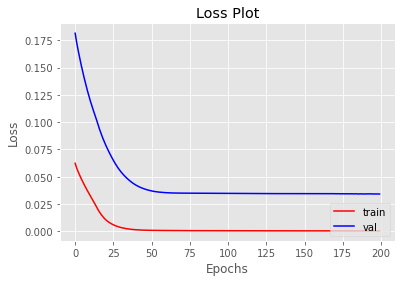

In [87]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

In [91]:
predicted= np.append(predicted,40*[0])

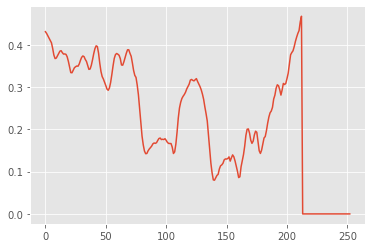

In [92]:
plt.plot(predicted)

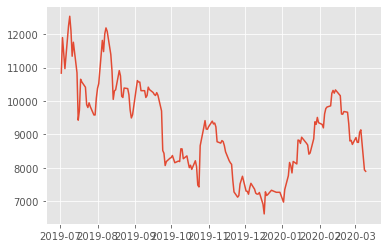

In [93]:
plt.plot(test_true)

In [78]:
np.shape(true)

(213,)

In [79]:
test_true.shape

(253,)

In [90]:
mse,rmse,r2_value,true,predicted = evaluate_model(model, test_pred, 40)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(test_true,predicted)

MSE = 0.026698332937634833
RMSE = 0.16339624517605914
R2-Score = 0.3600778580987445


ValueError: view limit minimum -36874.700000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [17]:
# Save a model
model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
#del model  #Deletes the model
# Load a model
#model = load_model('MV3-GRU_40_[40,35]_1e-4_64.h5')

## Cross Validation

In [42]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

In [43]:
do = data_prep_helper.ValidateChartData(chart_col=["Price", "High", "Low"])

In [44]:
# Normalisation
sc = MinMaxScaler()

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Split 1
MSE = 0.01768563853011588
RMSE = 0.13298736229475294
R-Squared Score = 0.6607419239715714


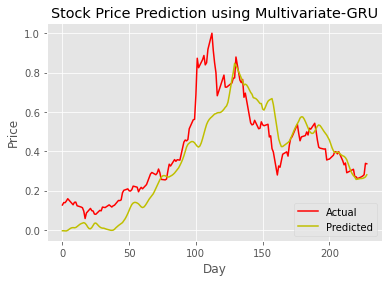

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Epoch 00180: early stopping
Split 1
MSE = 0.02945340286177222
RMSE = 0.17161993725022806
R-Squared Score = 0.6257722207408575


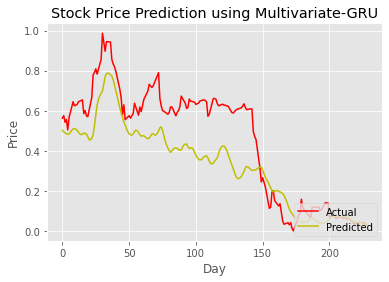

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Split 1
MSE = 0.0055753947487236985
RMSE = 0.07466856600152234
R-Squared Score = 0.8417390037032941


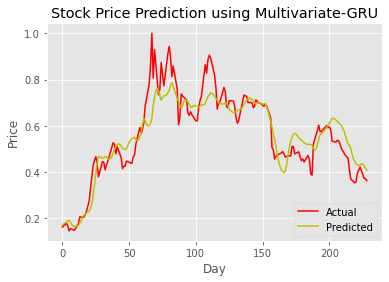

In [45]:
for train, test in do.gen_return_splits():
    train = train[features]
    test = test[features]
    train = sc.fit_transform(train)
    test = sc.fit_transform(test)
    cross_val_results = list()
    train_loss = pd.DataFrame()
    val_loss = pd.DataFrame()
    model,train_error,val_error = fit_model(train, test,timesteps,hl,lr,batch_size,num_epochs)
    train_loss['Split1'] = train_error
    val_loss['Split1'] = val_error
    mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
    print("Split 1")
    print('MSE = {}'.format(mse))
    print('RMSE = {}'.format(rmse))
    print('R-Squared Score = {}'.format(r2_value))
    plot_data(true,predicted)
    cross_val_results.append([mse,rmse,r2_value,0])